In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.stats
from importlib import reload
import tqdm
import time
import copy
from prettytable import PrettyTable
from matplotlib.ticker import PercentFormatter

ModuleNotFoundError: No module named 'prettytable'

In [ ]:
def main(resmapleing):
  M = 10**3  # M experiments
  k_max = 5  # we want to compute Var(Y^k), for k=1,2,3,4,5, Y=1/n sum_i(y_i) is the resampled estimator
  sigma_list = [0.25*i for i in range(1,8)]
  j_max =  len(sigma_list)
  result = np.zeros((M, k_max, j_max))

  for i in range(M):
    N = 10**4  # draw N samples from pi: N(0,1)
    X = np.random.normal(0, 1, N)
    for j in range(j_max):  # pi tilde: N(0,sigma^2)
      sigma = sigma_list[j]
      W = (1/sigma)*np.exp(X**2*(1/2-1/(2*sigma**2)))  # compute the sample weight
      W /= np.sum(W)  # normalize sample weight
      W_new = resmapleing(W, N)
      for k in range(k_max):  # compute Y^k
        result[i, k, j] = np.sum((X**(k+1))*W_new)
  var_table = np.var(result, axis=0)  # compute the variance using M experiments
  return var_table # return a table

In [ ]:
def draw_table(var_table):
  var_new = np.round(var_table, decimals=8)
  x = PrettyTable()
  title_list = []
  sigma_list = [0.25*j for j in range(1,8)]
  title_list = ["k\sigma"]
  for i in sigma_list:
    title_list.append(str(i))
  x.field_names = title_list
  for i in range(len(var_new)):
      row = var_new[i,:]
      row_new = [i+1]
      for j in row:
        row_new.append(j)
      x.add_row(row_new)
  print(x)

In [ ]:
def multinomial(W, N):
  W_new = np.random.multinomial(N, W)/N  # W_new is the mean of all new samples
  return W_new

var_table = main(multinomial)
draw_table(var_table)

+---------+-----------+-----------+------------+------------+-------------+---------------+----------------+
| k\sigma |    0.25   |    0.5    |    0.75    |    1.0     |     1.25    |      1.5      |      1.75      |
+---------+-----------+-----------+------------+------------+-------------+---------------+----------------+
|    1    | 1.578e-05 | 4.405e-05 | 9.943e-05  | 0.00020141 |  0.0006259  |   0.00684042  |   0.0506068    |
|    2    |  1.71e-06 | 2.047e-05 | 9.513e-05  | 0.00040941 |  0.00381775 |   0.1149309   |   0.91334511   |
|    3    |  5.4e-07  | 2.791e-05 | 0.00039016 | 0.00297821 |  0.07536336 |    3.47854    |  30.37326789   |
|    4    |  2.1e-07  | 4.495e-05 | 0.00118487 | 0.01960656 |  1.23672998 |  80.45757538  |  706.15395439  |
|    5    |  1.1e-07  |  9.69e-05 | 0.00659407 | 0.18592521 | 28.90503551 | 2239.57898931 | 20346.80934978 |
+---------+-----------+-----------+------------+------------+-------------+---------------+----------------+


In [ ]:
def Bernoulli(W, N):
  N = len(W)
  W_floor = np.floor(W*N)
  random = W*N-W_floor-np.random.rand(N)
  random[random>=0] = 1
  random[random<0] = 0
  W_new = (W_floor+random)/np.sum(W_floor+random)  # new weight is 1/N' for each new sample, N&N' may differ
  return W_new

var_table = main(Bernoulli)
draw_table(var_table)

+---------+----------+-----------+------------+------------+-------------+--------------+---------------+
| k\sigma |   0.25   |    0.5    |    0.75    |    1.0     |     1.25    |     1.5      |      1.75     |
+---------+----------+-----------+------------+------------+-------------+--------------+---------------+
|    1    |  1e-05   | 2.796e-05 | 5.757e-05  | 9.792e-05  |  0.0004235  |  0.00423679  |   0.02778263  |
|    2    | 1.22e-06 | 1.424e-05 | 6.677e-05  | 0.00019955 |  0.00287333 |  0.05820151  |   0.42056995  |
|    3    |  4e-07   | 2.381e-05 | 0.00024894 | 0.00152244 |  0.05306099 |  1.56891056  |  12.81982162  |
|    4    | 1.6e-07  | 3.699e-05 | 0.00092988 | 0.00983916 |  0.82315142 | 30.50959228  |  253.99962609 |
|    5    |  9e-08   | 9.608e-05 | 0.00503946 | 0.09498541 | 16.77857166 | 751.74729533 | 6647.56356316 |
+---------+----------+-----------+------------+------------+-------------+--------------+---------------+


In [ ]:
def systematic(W, N):
  N = len(W)
  cumulative_W = np.cumsum(W)  # project onto [0,1]
  unif = (np.random.random() + np.arange(N))/N
  W_new = np.zeros(N)
  i = 0
  j = 0
  while i < N:
    if unif[i] < cumulative_W[j]:
      W_new[j] += 1   # counting the number of copy for X_j
      i += 1
    else:
      j += 1
  W_new /= N  # normalize
  return W_new
var_table = main(systematic)
draw_table(var_table)

+---------+-----------+-----------+------------+------------+------------+--------------+---------------+
| k\sigma |    0.25   |    0.5    |    0.75    |    1.0     |    1.25    |     1.5      |      1.75     |
+---------+-----------+-----------+------------+------------+------------+--------------+---------------+
|    1    | 1.046e-05 | 3.038e-05 | 5.863e-05  | 9.092e-05  | 0.0004051  |  0.00432545  |   0.02931664  |
|    2    |  1.04e-06 | 1.377e-05 | 7.007e-05  | 0.00021015 | 0.00291815 |  0.0616427   |   0.45996504  |
|    3    |  3.8e-07  | 2.333e-05 | 0.00027876 | 0.00143784 | 0.05346047 |  1.68881474  |  14.16525748  |
|    4    |  1.4e-07  | 4.073e-05 | 0.00097547 | 0.0099545  | 0.83979794 | 33.97220787  |  292.7664714  |
|    5    |   9e-08   | 9.142e-05 | 0.00537666 | 0.09356557 | 17.2272148 | 853.65246107 | 7778.54917287 |
+---------+-----------+-----------+------------+------------+------------+--------------+---------------+


In [2]:
def SAW(D, N, L, resample=False): 
  # D is the length of walk, N is the sample size, L is the length of lattice
  all_walk = np.zeros((D, N, 2))
  weight = np.zeros(N)
  all_walk[0, :, :] = np.random.randint(0, high=L, size=(N, 2))
  weight = np.ones(N)/N  # uniform weights
  all_move = np.array([(1,0), (0,1), (-1,0), (0,-1)])  # 4 possible directions
  for d in range(1, D):  # d^th step
    for n in range(N):  # n^th sample
      m = 0
      current = all_walk[d-1, n, :]   # position at last step
      valid_list = []
      for move in all_move:
        proposal = (current + move)%L  # periodic lattice (0, ..., L-1)^2
        if not repeat(proposal, all_walk[:d, n, :]):
          m += 1 
          valid_list.append(proposal)
      if m >= 0.5:  # random walk not stucked
        all_walk[d, n, :] = valid_list[np.random.randint(0,len(valid_list))]   # randomly choose a valid direction
      weight[n] *= m  # update weight
    weight /= np.sum(weight)  # normalize weight

    if resample == True:  # if using systematic resample
      index = systematic_resampling(weight)
      current_copy = copy.deepcopy(all_walk)
      for i in range(len(index)):
        all_walk[:,i,:] = current_copy[:,index[i],:]  # copy the index[i]^th sample
      weight = np.ones(N)/N  # renew the uniform weights

  return all_walk, weight # each element in all_walk is an independent self-avoid random walk of length d anf the corresponding weight in weights

In [3]:
def systematic_resampling(weights):
  N = len(weights)
  unif = (np.random.random() + np.arange(N)) / N
  indexes = np.zeros(N, 'i')
  cumulative_sum = np.cumsum(weights)
  i, j = 0, 0
  while i < N:
      if unif[i] < cumulative_sum[j]:
          indexes[i] = j
          i += 1
      else:
          j += 1
  return indexes

In [4]:
def repeat(proposal, history):
  for position in history:
    if np.sum(np.abs(position-proposal))<= 0.5:
      return True
  return False

In [5]:
def plot_walk(X, Y, L): 
  # at position (X, Y), with lattice length L
  n = len(X)
  walk = plt.figure(figsize = (8, 8))
  plt.plot(X, Y, 'bo-', linewidth = 1)
  plt.plot(X[0], Y[0], 'go', ms = 5, label = 'Start')
  plt.plot(X[-1], Y[-1], 'ro', ms = 5, label = 'End')
  plt.axis('equal')
  plt.legend(fontsize=15)
  plt.title('SAW of length ' + str(n), fontsize=16)
  plt.show()
  return walk

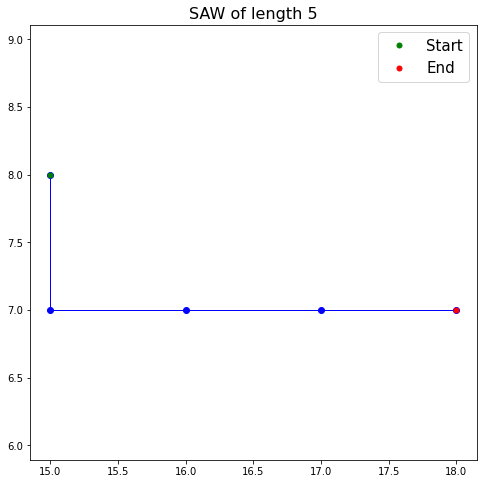

In [ ]:
N, D, L = 4, 5, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0], all_walk[:, 2, 1]
plot = plot_walk(X, Y, L)

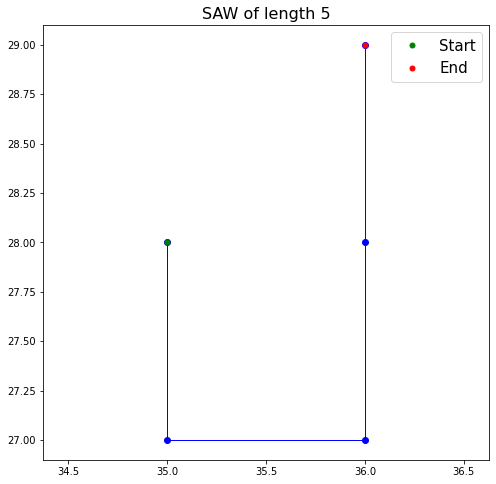

In [ ]:
N, D, L = 4, 5, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0, True], all_walk[:, 2, 1, True]
plot = plot_walk(X, Y, L)

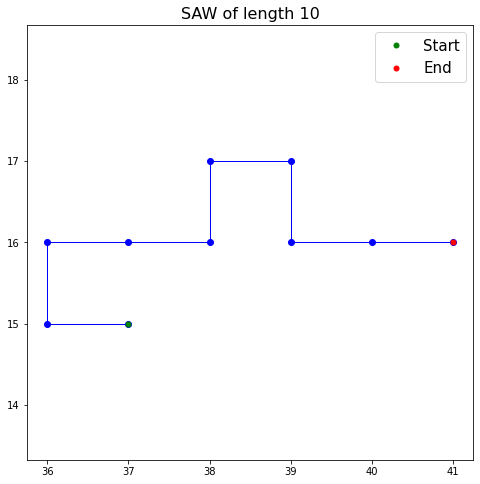

In [ ]:
N, D, L = 4, 10, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0], all_walk[:, 2, 1]
plot = plot_walk(X, Y, L)

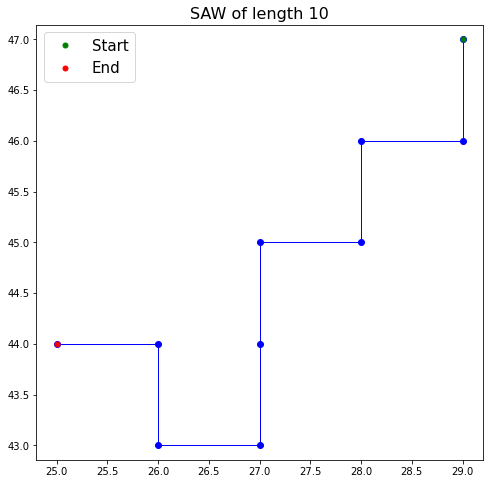

In [ ]:
N, D, L = 4, 10, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0, True], all_walk[:, 2, 1, True]
plot = plot_walk(X, Y, L)

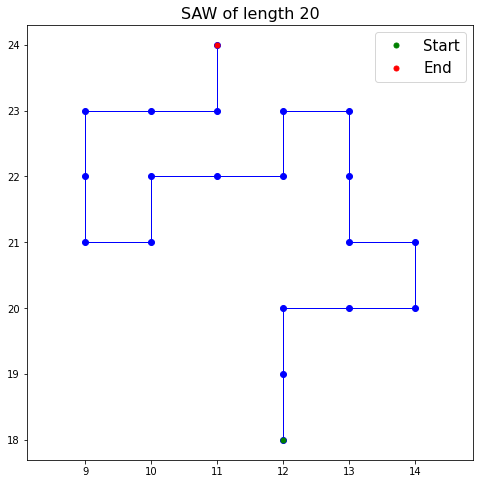

In [ ]:
N, D, L = 4, 20, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0], all_walk[:, 2, 1]
plot = plot_walk(X, Y, L)

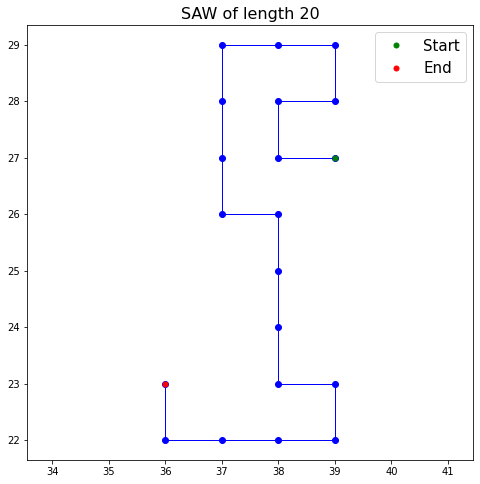

In [ ]:
N, D, L = 4, 20, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0, True], all_walk[:, 2, 1, True]
plot = plot_walk(X, Y, L)

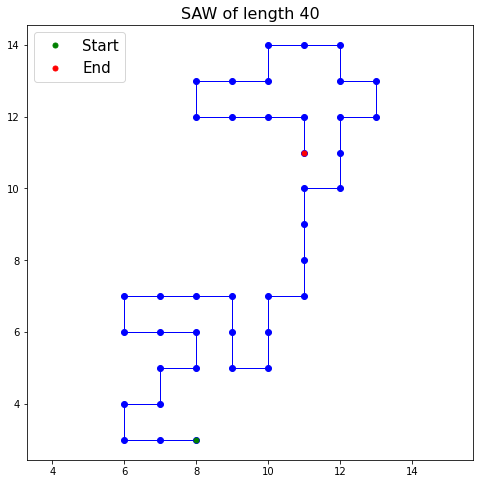

In [ ]:
N, D, L = 4, 40, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0], all_walk[:, 2, 1]
plot = plot_walk(X, Y, L)

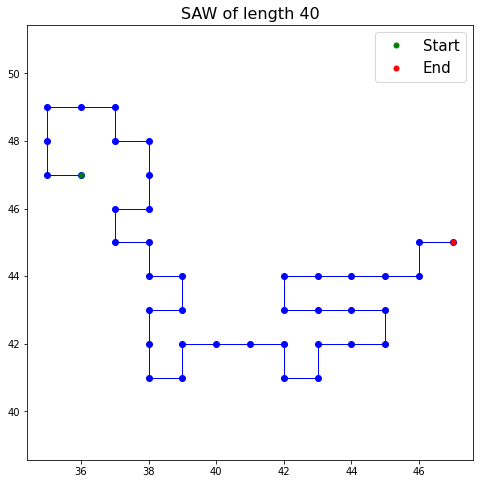

In [ ]:
N, D, L = 4, 40, 50
all_walk, weight = SAW(D, N, L)
X, Y = all_walk[:, 2, 0, True], all_walk[:, 2, 1, True]
plot = plot_walk(X, Y, L)

In [6]:
def test(res):
  N = 5*10**4
  D = 40
  L = 50
  start = time.time()
  all_walk, weight = SAW(D, N, L, resample = res)
  end = time.time()
  print('time comsumption: ', end-start)
  density = np.zeros((L, L))
  all_walk = all_walk.astype(int)
  for n in range(N):
    path = all_walk[:,n,:]
    for position in path:
      density[position[0], position[1]] += weight[n]
  density /= density.sum()
  return density

In [7]:
def plot_test(density):
  fig, ax = plt.subplots()
  min_val, max_val = 0, 50
  ax.matshow(density, cmap=plt.cm.Blues)

In [8]:
density_false = test(False)

time comsumption:  1007.12881731987


In [10]:
np.var(density_false)

1.5037067879811122e-09

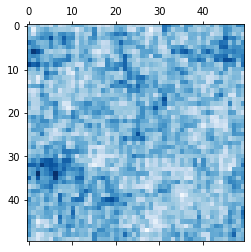

In [12]:
plot_test(density_false)

In [9]:
density_true = test(True)

time comsumption:  1109.1745958328247


In [11]:
np.var(density_true)

8.406189999999643e-10

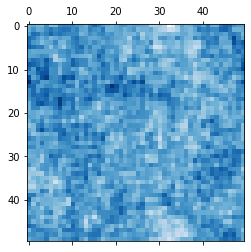

In [13]:
plot_test(density_true)

In [15]:
def SAW_Zn(D, N, L, resample=False): 
  # D is the length of walk, N is the sample size, L is the length of lattice
  all_walk = np.zeros((D, N, 2))
  weight = np.zeros(N)
  all_walk[0, :, :] = np.random.randint(0, high=L, size=(N, 2))
  weight = np.ones(N)/N  # uniform weights
  all_move = np.array([(1,0), (0,1), (-1,0), (0,-1)])  # 4 possible directions
  Z_list = np.zeros(D)
  Z_list[0] = L*L
  for d in range(1, D):  # d^th step
    M = 0  # count sum of possible move for each sample
    for n in range(N):  # n^th sample
      m = 0
      current = all_walk[d-1, n, :]   # position at last step
      valid_list = []
      for move in all_move:
        proposal = (current + move)%L  # periodic lattice (0, ..., L-1)^2
        if not repeat(proposal, all_walk[:d, n, :]):
          M += 1
          m += 1 
          valid_list.append(proposal)
      if m >= 0.5:  # random walk not stucked
        all_walk[d, n, :] = valid_list[np.random.randint(0,len(valid_list))]   # randomly choose a valid direction
      weight[n] *= m  # update weight
    weight /= np.sum(weight)  # normalize weight

    if resample == True:  # if using systematic resample
      index = systematic_resampling(weight)
      current_copy = copy.deepcopy(all_walk)
      for i in range(len(index)):
        all_walk[:,i,:] = current_copy[:,index[i],:]  # copy the index[i]^th sample
      weight = np.ones(N)/N  # renew the uniform weights
    # calculate Z_n
    Z_list[d] = Z_list[d-1]*M/N
  return Z_list

In [16]:
N = 10**4
D = 40
L = 50
Z_list = SAW_Zn(D, N, L, resample = True)

In [17]:
print(Z_list)

[2.50000000e+03 1.00000000e+04 3.00000000e+04 9.00000000e+04
 2.50524000e+05 7.11012164e+05 1.94781782e+06 5.43791780e+06
 1.48275705e+07 4.06883361e+07 1.10546140e+08 3.02045219e+08
 8.16730274e+08 2.21807608e+09 5.97727141e+09 1.61475987e+10
 4.33627616e+10 1.16307599e+11 3.11715997e+11 8.38921261e+11
 2.25149688e+12 6.03311104e+12 1.61458118e+13 4.32223381e+13
 1.15550599e+14 3.09086297e+14 8.24116792e+14 2.20665512e+15
 5.87323328e+15 1.57091370e+16 4.17753081e+16 1.11013704e+17
 2.95496277e+17 7.87408929e+17 2.09639753e+18 5.57914275e+18
 1.48421935e+19 3.93332969e+19 1.04575437e+20 2.77783732e+20]


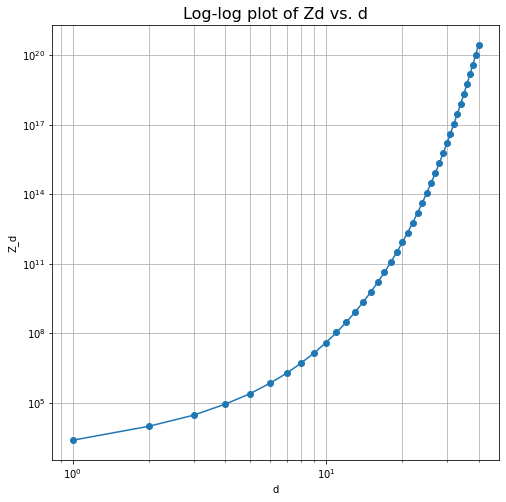

In [19]:
D_list = [d for d in range(1,D+1)]
plt.figure(figsize = (8, 8))
plt.plot(D_list, Z_list, 'o-')
plt.xlabel('d')
plt.ylabel('Z_d')
plt.xscale('log')
plt.yscale('log')
plt.grid(visible=True, which='both', axis='both')
plt.title('Log-log plot of Zd vs. d', 
          fontsize=16)
plt.show()